In [1]:
import csv
import os
import random
import numpy as np
import pandas as pd
from traces_dataset import Traces_Dataset
import ast
import torch 
from MLP_model import Net

In [6]:
dataset = Traces_Dataset('dataset_test.csv')

In [3]:
exp_narva_df = pd.read_csv('experiment records narval new.csv')

In [4]:
normalized_mean = torch.tensor(ast.literal_eval(exp_narva_df['normalize_mean'][15]))
normalized_std = torch.tensor(ast.literal_eval(exp_narva_df['normalize_std'][15]))

In [5]:
dataset.clean_features()

In [6]:
dataset.normalize_test(normalized_mean, normalized_std)

In [7]:
target_params = dataset.params

In [8]:
import torch

# Specify the path to your saved model
model_path = exp_narva_df['model'][15]

# Load the model with map_location
device = torch.device('cpu')  # Map tensors to CPU
model = torch.load(model_path, map_location=device)

In [9]:
model = Net(dataset.inputs.shape[1])

In [10]:
model.load_state_dict(torch.load(exp_narva_df['model'][15], map_location=device))

<All keys matched successfully>

In [11]:
estimated_params = model(dataset.inputs)

In [12]:
estimated_params.shape, target_params.shape

(torch.Size([1000, 8]), torch.Size([1000, 8]))

In [13]:
mse_each_param = (estimated_params - target_params)**2
print(mse_each_param)

tensor([[4.8016e+00, 2.2343e+00, 3.1916e+00,  ..., 8.5660e-01, 9.9321e-01,
         2.2983e-02],
        [6.6767e-02, 3.2031e-01, 1.8418e-02,  ..., 7.6059e-04, 3.6957e-01,
         2.3242e-02],
        [1.8740e+00, 2.4259e-01, 2.5492e-03,  ..., 2.0309e+00, 3.1924e-01,
         4.7253e-01],
        ...,
        [4.0961e+01, 5.9379e+01, 1.8904e-02,  ..., 4.5999e+00, 1.3634e-01,
         3.2624e-01],
        [4.7879e-01, 3.6489e-01, 1.0378e-02,  ..., 6.8852e+00, 1.4496e-01,
         1.1568e+00],
        [9.5371e+00, 2.3254e+01, 5.3095e-02,  ..., 5.9517e-02, 2.9019e-01,
         8.8415e-02]], grad_fn=<PowBackward0>)


In [14]:
avg_mse_each_param = torch.mean((estimated_params - target_params)**2, dim=0)
print(avg_mse_each_param)

tensor([12.9173, 10.4419,  0.5615, 10.0132,  2.8792, 12.5059,  1.1472,  2.0171],
       grad_fn=<MeanBackward1>)


In [15]:
overall_mse = torch.mean(avg_mse_each_param)
print(overall_mse)

tensor(6.5604, grad_fn=<MeanBackward0>)


In [16]:
avg_re_each_param = torch.mean(((estimated_params - target_params)/target_params)**2, dim=0)
print(avg_re_each_param)

tensor([9.8675e-04, 1.2993e-03, 5.0390e-02, 2.8947e+01, 1.2528e-01, 5.2929e-01,
        5.1218e-02, 8.3912e-02], grad_fn=<MeanBackward1>)


In [17]:
overall_re = torch.mean(avg_re_each_param)
print(overall_re)

tensor(3.7236, grad_fn=<MeanBackward0>)


### Visualization

In [2]:
dataset = Traces_Dataset('dataset_test_50.csv')

In [3]:
dataset.time_traces.shape, dataset.current_traces.shape, dataset.params.shape

(torch.Size([3, 12, 20]), torch.Size([3, 12, 20]), torch.Size([3, 728]))

In [4]:
target_time_traces_set = dataset.time_traces.numpy()
target_current_traces_set = dataset.current_traces.numpy()
target_params_set = dataset.params.numpy()

In [5]:
M_ha = 2
M_hb = 5
V_2ha = -40
V_2hb = -35
s_ha = 6
s_hb = -10
X_h = [M_ha, M_hb, V_2ha, V_2hb, s_ha, s_hb]

param_bounds_wo_h_dict = {'g_max': [100.0, 140.0],
                'E_rev': [-100, -80],

                'M_ma': [0, 50],
                'M_mb': [0, 50],
                'V_2ma': [-60, 60],
                #'V_2ma': [10, 100],
                'V_2mb': [-60, 60],
                's_ma': [-50, -0.5],  # excluding small abs values to avoid operating error in exp
                's_mb': [0.5, 50]}

input = {'p': 4,
        'q': 0,
        'step_Vs': np.array([0.00, 10.00, 20.00, 30.00, 40.00, 50.00, 60.00, 70.00, 80.00]), # mV
        'prestep_Vs': np.array([-80, -50, -20]),
        'step_V': 80,
        'prestep_V': -100,  #mV
        'end_time': 6,
        'time_step': 0.01,
        'X_h': X_h,
        'param_bounds_wo_h': param_bounds_wo_h_dict}

n_points = 20

In [6]:
def find_steady_state(V, X): 
# Find the steady-state curve at a fixed V, x goes to steady_state as t increses
# V: membrane voltage
# X: the activation or inactivation parameter set
    return 1 / (1 + X[1]/X[0] * (1+np.exp((V-X[2])/X[4]))/(1+np.exp((V-X[3])/X[5])))


def find_time_constant(V, X): 
    '''
    Find the time constant curve at a fixed V, it governs the rate at which x approaches to the steady state at a fixed V.
    V: membrane voltage
    X: the activation or inactivation parameter set
    '''
    return 1 / (X[0]/(1+np.exp((V-X[2])/X[4])) + X[1]/(1+np.exp((V-X[3])/X[5])))

# Construct the model
def openclose_rates_fixedV(V, X): 
    '''
    Find the rates of opening and closing of the activation(m)/inactivation(h) gates using hyperbolic tangent functions
    V is the applied memebrane voltage
    X is the parameter set associated with activation/inactivation term 
    '''
    a = (X[0]) / (1 + np.exp((V - X[2]) / X[4]))
    b = (X[1]) / (1 + np.exp((V - X[3]) / X[5]))
    return a, b

def find_x_fixedV(a, b, t_steps, init_cond): 
    '''
    Find the activation/inactivation variable analytically with I.C. x(0) = initial_cond
    a, b: the opening and closing rates of of the activation/inactivation gates
    t_steps
    '''
    return (a - (a - (a + b) * init_cond) * np.exp(-t_steps * (a + b))) / (a + b)

def find_I(p, q, V, m, h, g_max, E_rev):
    return g_max * np.power(m, p) * np.power(h, q) * (V - E_rev) 

In [7]:
def get_current_trace(time_traces, parameters):
    '''
    time_points: np array of n_points time points
    parameters: np array of len(params)

    return a 1d np array

    '''
    current_traces_3d = np.empty((len(input['step_Vs'])+len(input['prestep_Vs']), n_points))

    g_max = parameters[0]
    E_rev = parameters[1]
    X_m = parameters[2:]

    for i in range(time_traces.shape[0]):
        if i < len(input['step_Vs']):
            step_ms = np.array([find_x_fixedV(openclose_rates_fixedV(input['step_Vs'][i], X_m)[0], openclose_rates_fixedV(input['step_Vs'][i], X_m)[1], time_traces[i], find_steady_state(input['prestep_V'], X_m))])
            step_hs = np.array([find_x_fixedV(openclose_rates_fixedV(input['step_Vs'][i], X_h)[0], openclose_rates_fixedV(input['step_Vs'][i], X_h)[1], time_traces[i], find_steady_state(input['prestep_V'], X_h))])
            step_Is = find_I(input['p'], input['q'], input['step_Vs'][i], step_ms, step_hs, g_max, E_rev)
            current_traces_3d[i, :] = step_Is

        else:
            j = i - len(input['step_Vs'])
            prestep_ms = np.array([find_x_fixedV(openclose_rates_fixedV(input['step_V'], X_m)[0], openclose_rates_fixedV(input['step_V'], X_m)[1], time_traces[i], find_steady_state(input['prestep_Vs'][j], X_m))])
            prestep_hs = np.array([find_x_fixedV(openclose_rates_fixedV(input['step_V'], X_h)[0], openclose_rates_fixedV(input['step_V'], X_h)[1], time_traces[i], find_steady_state(input['prestep_Vs'][j], X_h))])
            prestep_Is = find_I(input['p'], input['q'], input['step_V'], prestep_ms, prestep_hs, g_max, E_rev)
            current_traces_3d[i, :] = prestep_Is
    #print(step_Is.shape, prestep_Is.shape, current_traces_3d.shape)

    return current_traces_3d

In [8]:
get_current_trace(target_time_traces_set[0], target_params_set[0])[0]

/var/folders/7_/yd2c8wld3sggx9gtmv9ydwm80000gn/T/ipykernel_85410/3299386803.py:33: RuntimeWarning: invalid value encountered in divide
  return (a - (a - (a + b) * init_cond) * np.exp(-t_steps * (a + b))) / (a + b)
/var/folders/7_/yd2c8wld3sggx9gtmv9ydwm80000gn/T/ipykernel_85410/3299386803.py:23: RuntimeWarning: overflow encountered in exp
  a = (X[0]) / (1 + np.exp((V - X[2]) / X[4]))
/var/folders/7_/yd2c8wld3sggx9gtmv9ydwm80000gn/T/ipykernel_85410/3299386803.py:24: RuntimeWarning: overflow encountered in exp
  b = (X[1]) / (1 + np.exp((V - X[3]) / X[5]))


array([-0.00042741, -0.00042741, -0.00042741, -0.00042741, -0.00042741,
       -0.00042741, -0.00042742, -0.00042742, -0.00042742, -0.00042742,
       -0.00042742, -0.00042742, -0.00042742, -0.00042742, -0.00042742,
       -0.00042742, -0.00042742, -0.00042742, -0.00042742, -0.00042742])

In [9]:
target_current_traces_set[0][0]

array([0.11005495, 0.11505631, 0.12007304, 0.12640785, 0.13350104,
       0.14203839, 0.15312302, 0.16842942, 0.19465245, 0.43      ,
       0.        , 0.01490756, 0.02068502, 0.02375332, 0.02682163,
       0.02988993, 0.03209073, 0.03425926, 0.03642778, 0.0385963 ],
      dtype=float32)

In [ ]:
simulated_current_traces = get_current_trace(target_t_traces, gens_best_sol[-1])
plt.figure()
for i in range(0,len(input['step_Vs'])+len(input['prestep_Vs'])):
    labeli = "target :{:.2f}".format(i)
    labeli_esti = "estimated :{:.2f}".format(i)
    plt.plot(target_t_traces[i], target_current_traces[i], label=labeli, linewidth=0.5, linestyle='dotted', color = 'black')
    plt.plot(target_t_traces[i], simulated_current_traces[i], label=labeli_esti, linewidth=0.5, color='red')
plt.title('Simulated trace of the best estimated parameters')
plt.xlabel('t (ms)')
plt.ylabel('I (mA)')
plt.savefig(f'GA_plots/plots {unique_id}')

In [37]:
torch.mean(torch.abs(estimated_params - target_params), dim=0)

tensor([2.0445, 2.1822, 0.5177, 1.5369, 1.0354, 1.9922, 0.7094, 0.8122],
       grad_fn=<MeanBackward1>)

In [38]:
torch.mean(torch.abs(estimated_params - target_params)/target_params, dim=0)

tensor([ 0.0174, -0.0243,  0.0524,  0.3906,  0.0152, -0.0410, -0.0751,  0.0723],
       grad_fn=<MeanBackward1>)

In [64]:
target_params[:30,0]

tensor([137.7534, 100.9615, 100.2674, 126.8070, 133.6569, 134.5118, 122.8965,
        135.1354, 136.6189, 125.1193, 101.4313, 137.4006, 114.4102, 120.4679,
        106.2957, 128.4062, 109.3695, 114.2768, 114.6344, 134.3343, 115.4184,
        138.0113, 127.9349, 133.6854, 127.7570, 133.5660, 104.8210, 121.6189,
        112.6048, 101.7184])

In [18]:
dataset = Traces_Dataset('dataset_test.csv')

In [19]:
dataset.time_traces.shape, dataset.current_traces.shape, dataset.params.shape

(torch.Size([1000, 12, 20]), torch.Size([1000, 12, 20]), torch.Size([1000, 8]))

In [20]:
target_time_traces_set = dataset.time_traces.numpy()
target_current_traces_set = dataset.current_traces.numpy()
target_params_set = dataset.params.numpy()

In [21]:
target_time_traces_set.shape, target_current_traces_set.shape, target_params_set.shape

((1000, 12, 20), (1000, 12, 20), (1000, 8))

In [22]:
from GA_test import ga_algorithm

Experiment ID: 02242f8d
1th Optimum Solution:  [126.37453773473953, -95.16332297574587, 42.49603694830214, 46.84126084460311, -28.1419849217663, 46.27405306568164, -49.9130407556979, 29.18659535644191]
{'Min': 3573369.981712279, 'Max': 25437601369.97638, 'Avg': 808396774.1874717, 'Std': 1305947258.9851706, 'Generation': 1}
{'Min': 3573369.981712279, 'Max': 22241451879.14263, 'Avg': 373684670.329789, 'Std': 1023787637.3722122, 'Generation': 2}
{'Min': 1388949.1078443902, 'Max': 17918240466.489082, 'Avg': 278449545.8911594, 'Std': 1099985896.8059814, 'Generation': 3}
{'Min': 1177856.2170139733, 'Max': 13627384183.894701, 'Avg': 225867272.3629187, 'Std': 811104616.5082501, 'Generation': 4}
{'Min': 862012.0460085326, 'Max': 13214319464.707167, 'Avg': 188738277.7378367, 'Std': 719257955.7519749, 'Generation': 5}
{'Min': 140766.12153353117, 'Max': 18449013123.788406, 'Avg': 176631871.00622925, 'Std': 737227672.666201, 'Generation': 6}
{'Min': 284207.8391312815, 'Max': 18588691403.79772, 'Avg

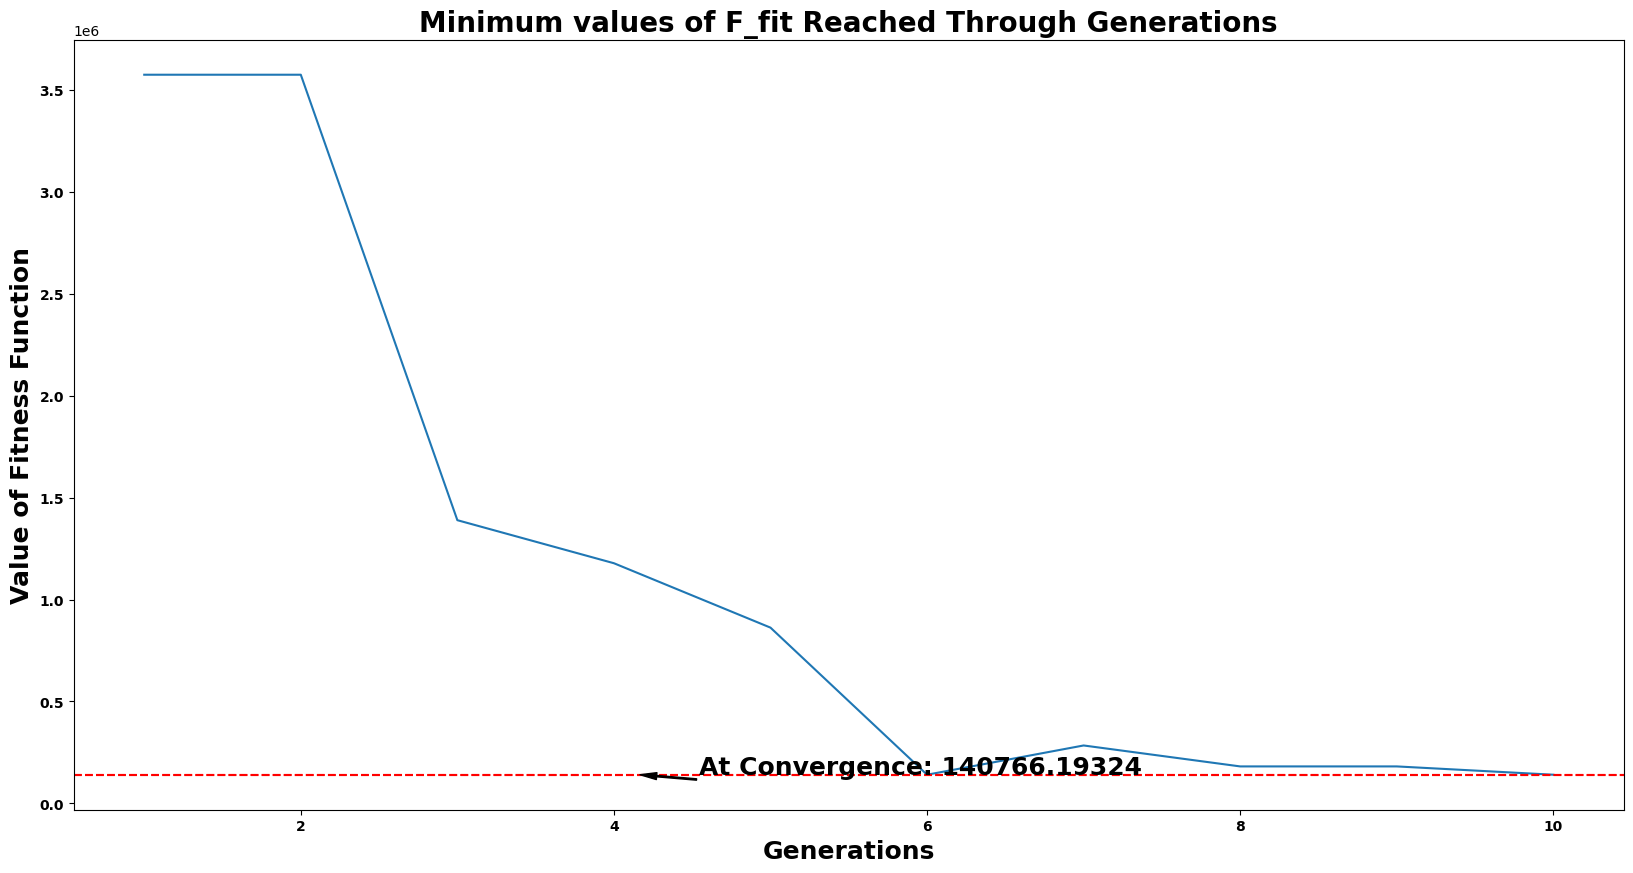

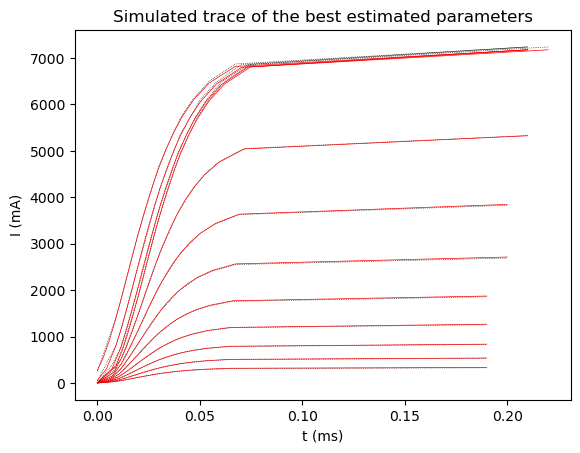

In [23]:
ga_algorithm(target_time_traces_set[0], target_current_traces_set[0], target_params_set[0])